## Plate Detection 
Younghoon Cho
### Dataset Used: 
https://www.kaggle.com/datasets/gpiosenka/us-license-plates-image-classification/data

### Plans for Project
1. Normalize from 0 to 1
2. expected size (3, w , h) RGB
3. Model Choice: *Convolutional Neural Network*
4. Train Details
    Data Augmentation : Not acceptable because the states are placed in a certain place. <br>
    Loss Functon : *Cross Entrophy Loss* <br>
    Optimizer : Adam or SGD (haven't chosen yet) <br>
    
### what I did (for myself too track)
1. resize the train, test, valid numbers
2. 1st attempt with my own cnn model 20% accuracy <br>
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))<br>
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))<br>
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))<br>
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)<br>
  (fc1): Linear(in_features=23296, out_features=256, bias=True)<br>
  (fc2): Linear(in_features=256, out_features=128, bias=True)<br>
  (fc3): Linear(in_features=128, out_features=56, bias=True)<br>
  (dropout): Dropout(p=0.5, inplace=False)<br>  
3. go with size 128, 128
4. decided to to data augmentation(make extra files) with brightness and contrast



Original image size: Width: 224, Height: 128


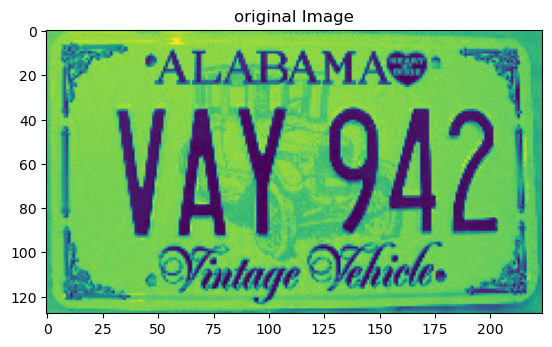

In [1]:
from torchvision import datasets, transforms
from PIL import Image
from matplotlib import pyplot as plt
# Example transform (without resize or crop)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load dataset without resizing or cropping
dataset = datasets.ImageFolder(root='./archive/plates/train', transform=transform)

# Access the first image in the dataset
img_path, _ = dataset.samples[0]  # Get the path of the first image
img = Image.open(img_path)        # Open the image with PIL

# Get the image size (width, height)
width, height = img.size

print(f"Original image size: Width: {width}, Height: {height}")

def Show_Image(Image, Picture_Name):
    plt.imshow(Image)
    plt.title(Picture_Name)
    plt.show()

Show_Image(dataset[0][0][1], 'original Image')


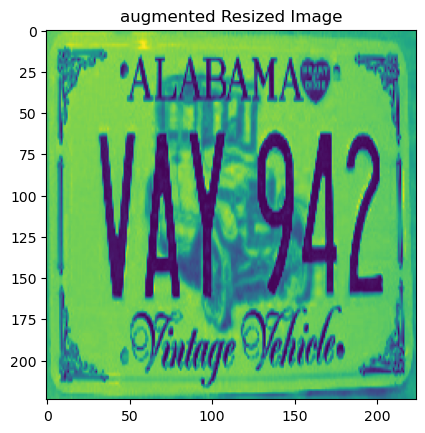

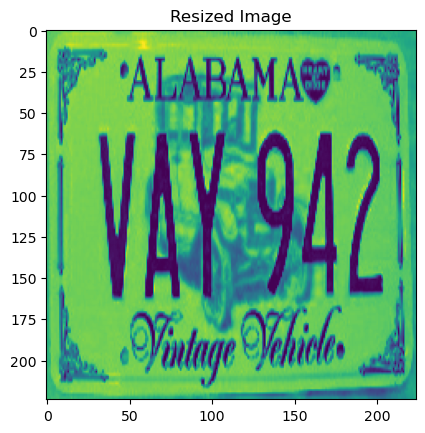

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])
torch.Size([64])
Device: mps


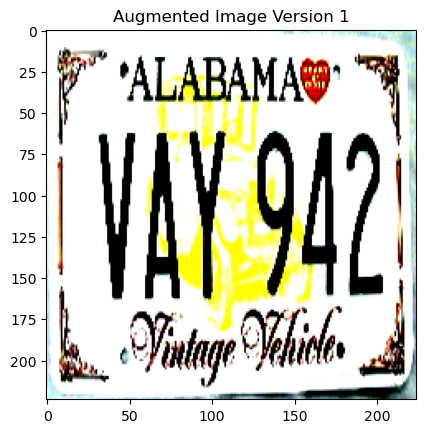

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


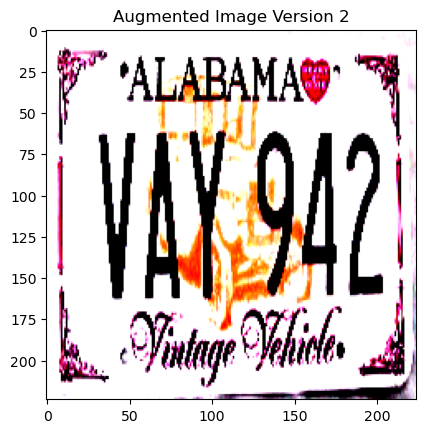

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


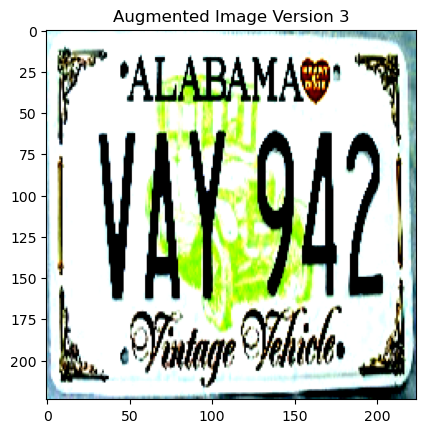

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import ConcatDataset

# for data augmenetation
from PIL import Image
import os
from torchvision.datasets import ImageFolder

# to see image
from matplotlib import pyplot as plt

def Show_Image(Image, Picture_Name):
    plt.imshow(Image)
    plt.title(Picture_Name)
    plt.show()


device=torch.device("cuda" if torch.cuda.is_available() else "mps")

# for data augmentation
augmentation_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224), antialias=True),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

transforms = transforms.Compose([
    transforms.Resize(size=(224, 224), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

# download 
train_dir = './archive/plates/train'
train_dir2 = './archive/new plates/train'

valid_dir = './archive/plates/valid'
valid_dir2 = './archive/new plates/valid'

test_dir = './to/archive/plates/test'
test_dir2 = './archive/new plates/test'

# Set random seed for consistance
random_state = 1
torch.manual_seed(random_state)

# Create datasets for plates and new plates
train_dataset = datasets.ImageFolder(root=train_dir, transform=transforms)
train_dataset2 = datasets.ImageFolder(root=train_dir2, transform=transforms)

# Augmented datasets using the defined transformations
augmented_train_dataset = datasets.ImageFolder(root=train_dir, transform=augmentation_transforms)
augmented_train_dataset2 = datasets.ImageFolder(root=train_dir2, transform=augmentation_transforms)

valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transforms)
valid_dataset2 = datasets.ImageFolder(root=valid_dir2, transform=transforms)

test_dataset = datasets.ImageFolder(root=valid_dir, transform=transforms)
test_dataset2 = datasets.ImageFolder(root=valid_dir2, transform=transforms)

Show_Image(augmented_train_dataset[0][0][2], 'augmented Resized Image')
Show_Image(train_dataset[0][0][2], 'Resized Image')

# Concatenate datasets
full_train_dataset = ConcatDataset([train_dataset, train_dataset2, augmented_train_dataset, augmented_train_dataset2])
full_valid_dataset = ConcatDataset([valid_dataset, valid_dataset2])
full_test_dataset = ConcatDataset([test_dataset, test_dataset2])

# Split dataset sizes
original_train_size = len(full_train_dataset)
train_size = int(0.7 * original_train_size)
valid_size = int(0.15 * original_train_size)
test_size = original_train_size - train_size - valid_size

train_dataset, add_valid_dataset, add_test_dataset = random_split(full_train_dataset, [train_size, valid_size, test_size])

# Combine validation and test datasets from the additional split
full_valid_dataset = ConcatDataset([full_valid_dataset, add_valid_dataset])
full_test_dataset = ConcatDataset([full_test_dataset, add_test_dataset])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(full_valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(full_test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


for images, labels in valid_loader:
    print(images.shape)  # Print the shape of the images
    print(labels.shape)  # Print the shape of the labels
    break  # Stop after the first batch to just check the dimensions

print(f'Device: {device}')

# original --> after redistribution of image (.7,.15,.15) --> after data augmentation
len(train_loader) # 15521 --> 10864 --> 21729
len(valid_loader) # 530 --> 2858 --> 5186
len(test_loader)  # 530 --> 2859 --> 5187

# Display the same image multiple times to show random augmentations
for i in range(3):
    img, _ = augmented_train_dataset[0]  # Access the first image multiple times
    Show_Image(img.permute(1, 2, 0), f'Augmented Image Version {i+1}')  # Show different augmented versions
# print(device)

### Original Dataset len()
len(train_loader) # 15521
len(valid_loader) # 530
len(test_loader)  # 530

because the dataet is too onesided to train_loader, I have moved 0.15 states each to valid_loader and test_loader

| name of data | previous | after resize data |
|--------------|----------|-------------------|
|train_loader|15521 (93%)| 10864(65.5%)|
|valid_loader|530 (3.5%) | 2858 (17.2%) |
|test_loader|530 (3.5%) | 2859 (17.2%) |

In [3]:
from torchsummary import summary

class plate_recognize_model(nn.Module):
    def __init__(self):
        super().__init__()

        # Model Structure
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 64, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Pooling layers
        self.pool = nn.MaxPool2d(2, 2)  # MaxPooling2D((2, 2))

        # Fully connected layers
        self.fc1 = nn.Linear(9216 , 512)  # Flatten and Dense(256, activation='relu')
        self.fc2 = nn.Linear(512, 256)  # Dense(256, activation='relu')
        self.fc3 = nn.Linear(256, 56)   # Dense(56, activation='softmax')

        # Dropout
        self.dropout = nn.Dropout(0.5)mistakeaasdeqwdfasdasdqwe

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        # Flatten the tensor for fully connected layers
        x = x.view(-1, 9216)  # Flatten from (128 * 16 * 28)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        
        # Apply softmax activation in the last layer
        x = F.softmax(self.fc3(x), dim=1)
        
        return x
    
# model is trying to convert to cpu..
model = plate_recognize_model().to(device)

# Print the model summary
print(model)
# summary(model, input_size=(3,224,224))

print(device)

plate_recognize_model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool): MaxPool2d(kernel_size

In [8]:
import torchvision.models as models

# pre-trained ResNet model
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = True

# Modify the final fully connected layer to output 56 classes
num_features = resnet.fc.in_features  # Get the input features for the fully connected layer
resnet.fc = nn.Linear(num_features, 56)  # Replace with a new fully connected layer with 56 outputs

In [9]:
import torch.optim as optim
import torch.nn as nn

# Set device to MPS if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def one_hot_encoding(targets, num_classes=56, device=device):
    return torch.eye(num_classes=56, device=device)[targets]

# Instantiate the model once and move it to the device
# model = plate_recognize_model().to(device)
model = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train function
def train(model, device, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        # print("Output shape:", output.shape)
        # print("Target shape:", target.shape)
        # Calculate loss with CrossEntropyLoss
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Track loss
        train_loss += loss.item()

        # Track accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct / total
    
    return avg_train_loss, train_accuracy

# Test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Calculate loss with CrossEntropyLoss
            loss = criterion(output, target)
            test_loss += loss.item()
            
            # Track accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / total
    return avg_test_loss, test_accuracy

# Training loop
num_epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy = train(
        model=model, device=device, train_loader=train_loader, optimizer=optimizer
    )
    avg_test_loss, test_accuracy = test(
        model=model, device=device, test_loader=test_loader
    )
    
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch {epoch}: \tTrain Loss: {avg_train_loss:.4f} \tTest Loss: {avg_test_loss:.4f}'
          + f'\tTrain Accuracy: {train_accuracy:.4f}, \tTest Accuracy: {test_accuracy:.4f}')

Epoch 0: 	Train Loss: 1.9533 	Test Loss: 1.2231	Train Accuracy: 0.3785, 	Test Accuracy: 0.4769
Epoch 1: 	Train Loss: 0.9225 	Test Loss: 0.8945	Train Accuracy: 0.5178, 	Test Accuracy: 0.4971
Epoch 2: 	Train Loss: 0.7949 	Test Loss: 0.8270	Train Accuracy: 0.5298, 	Test Accuracy: 0.5183
Epoch 3: 	Train Loss: 0.7582 	Test Loss: 0.9162	Train Accuracy: 0.5327, 	Test Accuracy: 0.4900
Epoch 4: 	Train Loss: 0.7697 	Test Loss: 0.8003	Train Accuracy: 0.5314, 	Test Accuracy: 0.5064
Epoch 5: 	Train Loss: 0.7166 	Test Loss: 0.8224	Train Accuracy: 0.5389, 	Test Accuracy: 0.5048
Epoch 6: 	Train Loss: 0.7433 	Test Loss: 0.8585	Train Accuracy: 0.5364, 	Test Accuracy: 0.5096
Epoch 7: 	Train Loss: 0.7236 	Test Loss: 0.8206	Train Accuracy: 0.5376, 	Test Accuracy: 0.5197
Epoch 8: 	Train Loss: 0.7145 	Test Loss: 0.7250	Train Accuracy: 0.5411, 	Test Accuracy: 0.5179
Epoch 9: 	Train Loss: 0.6935 	Test Loss: 0.7570	Train Accuracy: 0.5405, 	Test Accuracy: 0.5210
Epoch 10: 	Train Loss: 0.7022 	Test Loss: 1.0063	T

KeyboardInterrupt: 

## experiment History
|experiment<br> num|changes made|result|epoch|time|train_accuracy|test_accuracy|train_loss|test_loss|
|--------------|------------|------|-----|----|--------------|-------------|----------|---------|
|0.|initial attempt|2% accuracy|20|20min|0.0210|0.020|-|-|
|1.|1.added extra layers <br> 2. applied batch normalization|10% accuracy|20|40min|0.100|0.100|-|-|
|2.|1.increase learning rate from 0.001 to 0.01|no improvement|-|-|-|-|-|-|
|3.|1.increase epoch to 60|accuracy 13%|60|300min|0.13|0.12|-|-|
|4.|1.apply batch_size=32|accuracy increased almost 300% (36%), runtime reduced 86%|59|43min|0.3740|0.3565|3.6851|3.7014|
|5.|1.increase batch size to 64|similar to exp 4|60|42min|0.3632|0.3503|3.6953|3.7080|
|6.|1.increase epoch to 100 to see if the accuracy increases|increased, but the starting point wasn't good|96|84min|0.3991|0.3704|3.6597|3.6863|
|7.|1.increase epoch to 150 to see if the accuracy keep ncreases|increased, but the accuracy and loss started to flatten|149|384min|0.5088|0.4542|3.5498|3.6025|
|8.|1.for input, resize the input <br>from 128*128 --> 224*224|Accuracy until 0.40 has much faster, but started minimal improvements after|149|265min|0.4942|0.4597|3.5645|3.5974|
|9.|1.normalize in RGB (tried in Imagenette data)|didn't workout well, and the computer stopped due to low battery, which could have made the result slower|149|410min|0.4699|0.4323|3.5881|3.6239|
|10.|1.implement resnet18|baseline starts at 19% accuracy, but stopped at 25% and overfitted. did early stopping<br>train_loss went down to 2.1 and 2.5|||||||
|11.|1.remain resnet18, but unfreeeze the layers|baseline started at 147% accuracy, but stopped at 51% and started to overfit. did early stopping<br>train_loss went down less to 1|23|53min|0.5414|0.5141|0.6622|0.5141|

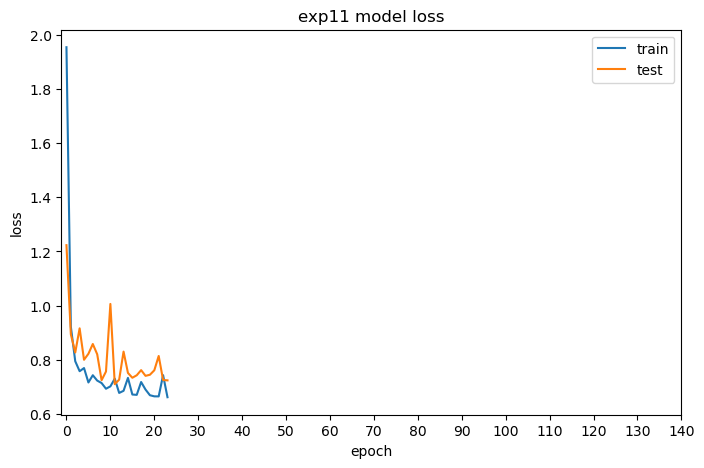

<Figure size 640x480 with 0 Axes>

In [10]:
import numpy as np
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('exp11 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,150, step=10))
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig("exp11_loss.pdf")

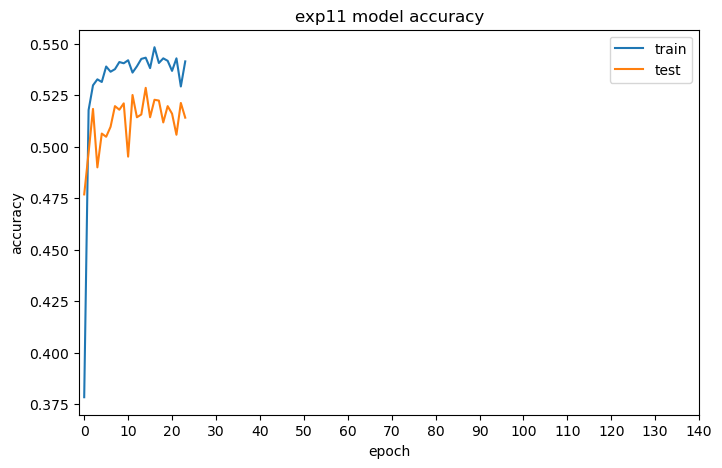

<Figure size 640x480 with 0 Axes>

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.title('exp11 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(0,150, step=10))
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.savefig("exp11_accuracy.pdf")